In this notebook, we're going to talk about some of the ways we can inspect the internals of a machine learning model to learn more about how it makes predictions.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score

# Load the dataset
diabetes_dataset = datasets.load_diabetes(as_frame=True)
df = diabetes_dataset.frame

# Rename the features for clarity
df = df.rename(columns={'s1': 'total serum cholesterol',
                        's2': 'low-density lipoproteins',
                        's3': 'high-density lipoproteins',
                        's4': 'total cholesterol',
                        's5': 'log of serum triglycerides',
                        's6': 'blood sugar'})

In [3]:
def generate_regressor(orig_df):
    """
    Train and test a regression model on the input DataFrame, returning the
    regressor, the feature names, and a dictionary of all the relevant data
    orig_df: the input DataFrame
    """
    # Set random number generator so the results are always the same
    np.random.seed(42)

    # Get the names of the features
    feature_names = df.columns.tolist()
    feature_names.remove('target')

    # Split the data into train and test sets
    train_df, test_df = train_test_split(orig_df, test_size=0.2)

    # Separate features from labels
    x_train = train_df.drop('target', axis=1).values
    y_train = train_df['target'].values
    x_test = test_df.drop('target', axis=1).values
    y_test = test_df['target'].values

    # Create and train the model
    regr = LinearRegression()
    regr.fit(x_train, y_train)

    # Use the model to predict on the test set
    y_pred = regr.predict(x_test)

    # Create a nested dictionary of all the data for easier retrieval
    data = {'train': {'x': x_train, 'y': y_train},
            'test': {'x': x_test, 'y': y_test},
            'pred': {'x': x_test, 'y': y_pred}}
    return regr, feature_names, data

In [4]:
def generate_classifier(orig_df):
    """
    Train and test a classification model on the input DataFrame, returning the
    classifier, the feature names, and a dictionary of all the relevant data
    orig_df: the input DataFrame for regression
    """
    # Set random number generator so the results are always the same
    np.random.seed(42)

    # Copy the DataFrame since we will be modifying it
    df = orig_df.copy()

    # Get the names of the features
    feature_names = df.columns.tolist()
    feature_names.remove('target')

    # Turn the label into a binary variable
    df['target'] = df['target'] > 150

    # Split the data into train and test sets
    train_df, test_df = train_test_split(df, test_size=0.2)

    # Separate features from labels
    x_train = train_df.drop('target', axis=1).values
    y_train = train_df['target'].values
    x_test = test_df.drop('target', axis=1).values
    y_test = test_df['target'].values

    # Create and train the model
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)

    # Use the model to predict on the test set
    y_pred = clf.predict(x_test)

    # Create a nested dictionary of all the data for easier retrieval
    data = {'train': {'x': x_train, 'y': y_train},
            'test': {'x': x_test, 'y': y_test},
            'pred': {'x': x_test, 'y': y_pred}}
    return clf, feature_names, data

# What Is Feature Importance?

***Feature importance*** refers to the idea of quantifying the relevance of features that are used in a predictive model. Determining the importance of each feature can help us understand which features are most influential in determining the final predictions made by the model. By identifying important features, we can gain insights into the underlying patterns and relationships that drive the model's predictions, which can in turn help with feature selection, model interpretability, and improvements in the model's performance.  



Each category of machine learning model architectures (e.g., linear models, tree-based models) have its own mathematical underpinnings. Therefore, each category may require a different technique to inspect its internals. We will go over relevant techniques for the two models we built on our Diabetes Dataset — a linear regression model and a decision tree classifier — but these methods will generalize to many other model architectures.

# Feature Weights and Coefficients

Linear models like linear regression and logistic regression use weighted sums of input features to make predictions. Therefore, the magnitude and direction of these coefficients can give us a rough idea about feature importance as follows:

| Magnitude | Sign | Interpretation |
|-----------|------|----------------|
| Large | Positive | The feature is important and leads to larger ouptuts |
| Small | Positive | The feature is less important, but still leads to larger ouptuts |
| Large | Negative | The feature is important and leads to smaller ouptuts |
| Small | Negative | The feature is less important, but still leads to larger ouptuts |

**Important:** The table above assumes that all of the model's features have a similar scale. Imagine that we had two features: $F_1$, which ranges between 0 and 1; and $F_2$, which ranges between 0 and 100. Since the scale of $F_2$ is much larger than that of $F_1$, even small changes in $F_2$ can lead to larger changes in the prediction. As a result, $F_2$'s coefficient after model training is likely to be larger compared to $F_1$'s coefficient. This does not mean that $F_2$'s coefficient, but is rather a matter of adjusting scale.

Once you normalize the scale of your features, you can start answering questions like the following: "When I change this feature value by half a standard deviation, how does it influence the model's prediction?"

Let's inspect the coefficients of our linear regression model:

In [5]:
regr, feature_names, _ = generate_regressor(df)
importances = regr.coef_
for feature_name, importance in zip(feature_names, importances):
    print(f'Feature: {feature_name}, Score: {importance}')

Feature: age, Score: 37.904021350074835
Feature: sex, Score: -241.96436231273972
Feature: bmi, Score: 542.4287585162907
Feature: bp, Score: 347.70384391385596
Feature: total serum cholesterol, Score: -931.4888458835159
Feature: low-density lipoproteins, Score: 518.0622769833373
Feature: high-density lipoproteins, Score: 163.41998299131063
Feature: total cholesterol, Score: 275.3179015786486
Feature: log of serum triglycerides, Score: 736.1988589046838
Feature: blood sugar, Score: 48.67065743196508


We can also plot these coefficients in a bar chart to visually compare them. Let's look at both the signed and unsigned value of the coefficients so that we can compare both their magnitude and direction:

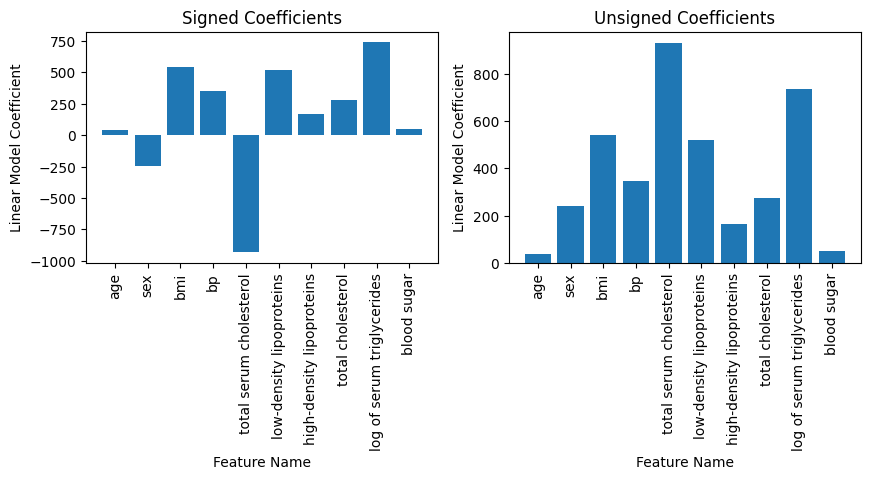

In [6]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.bar(feature_names, importances)
plt.xticks(rotation = 90)
plt.title('Signed Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Linear Model Coefficient')

plt.subplot(1, 2, 2)
plt.bar(feature_names, np.abs(importances))
plt.xticks(rotation = 90)
plt.title('Unsigned Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Linear Model Coefficient')
plt.show()

According to these graphs, we can see that total serum cholestorol has the strongest impact on the predictions from our linear regression model. Because it is negative, higher total serum cholesterol values will lead to lower predictions.

Log of serum triglycerides, BMI, and low-density lipoproteins seem to be the next most significant features, and they are all positive. Therefore, higher values for those features will lead to higher predictions.

# Decision Branches

Tree-based models like decision trees and random forests do not have coefficients. Instead, they use a series of learned rules to make predictions on input data. We can actually inspect these rules using the `plot_tree()` function in
the `tree` module of `scikit-learn`. Note that we are saving this figure to as an image file rather than showing it in this notebook. That is because we need to make the image quite large in order to see all of the rules:

In [7]:
from sklearn import tree

clf, feature_names, _ = generate_classifier(df)
plt.figure(figsize=(50, 50))
tree.plot_tree(clf, feature_names=feature_names, filled=True, fontsize=10)
plt.savefig('tree.jpg')
plt.close()

The rows within a node of the decision tree can be interpreted as follows:
1. **Rule:** The decision rule that dictates whether an input sample should go to the left or right.
2. **Gini:** We will cover this number in a bit, but this is a measure of the rule's importance within the tree according to our training set.
3. **Samples:** The number of training samples that made it to this point in the tree.
4. **Value:** The number of training samples that went to the left and to the right after this rule, respectively.

While visualizing the tree gives us definitive information about how the model is making decsions, it can be difficult to keep track of which feature values are relevant for a given input.

Furthermore, looking at the tree doesn't necessarily give us a clear idea of which features are most important to the overall model. Just because a node is higher in the decision tree does not mean that the corresponding feature is automatically more important.

# Purity-Based Importance Scores

One way we can rate the quality of a feature in a tree-based model is by seeing how effective it is at separating training samples belonging to different classes. Imagine we have a decision tree with three nodes:
* $N_{root}$: the node that makes a decision based on a rule
* $N_{yes}$: the node where samples that satisfy the rule land
* $N_{no}$: the node where samples that do not satisfy the rule land

If $N_{root}$ only has training samples from a single class, we would call it "pure". If $N_{root}$ has an equal mix of positive and negative samples, we would say that the node is "impure". There are lots of ways of measuring impurity, but one of the more common metrics that we will see is the ***Gini impurity***.

The rule in $N_{root}$ is effective if the nodes that follow it, $N_{yes}$ and $N_{no}$, both have higher purity than $N_{root}$. This mean that the rule is sorting through the disorder of the class distributions and separating training samples belonging to different classes.

We can measure the overall ***Gini importance score*** for a feature by averaging the total reduction in the Gini impurity across all the nodes in the tree that use the feature for splitting. Features that result in a significant reduction in the impurity are considered more important, as they contribute more to the overall purity and separation of the classes in the decision tree.

Gini importance scores range from 0 to 1, with higher values indicating greater importance. Unlike with the linear model coefficients, we cannot look at the Gini importance scores to determine whether features have a positive or negative impact on predictions. This is because there may be multiple nodes with conflicting rules based on how the data gets separated within lower levels of the tree.

Let's see what the Gini importance scores look like for our decision tree classifier:

In [8]:
importances = clf.feature_importances_
for feature_name, importance in zip(feature_names, importances):
    print(f'Feature: {feature_name}, Score: {importance}')

Feature: age, Score: 0.059585743075628
Feature: sex, Score: 0.014289183937823835
Feature: bmi, Score: 0.21100113799042636
Feature: bp, Score: 0.13687807873934194
Feature: total serum cholesterol, Score: 0.09747314203858556
Feature: low-density lipoproteins, Score: 0.13408154663005503
Feature: high-density lipoproteins, Score: 0.02182348092322186
Feature: total cholesterol, Score: 0.032317424955178885
Feature: log of serum triglycerides, Score: 0.2490595725516101
Feature: blood sugar, Score: 0.04349068915812849


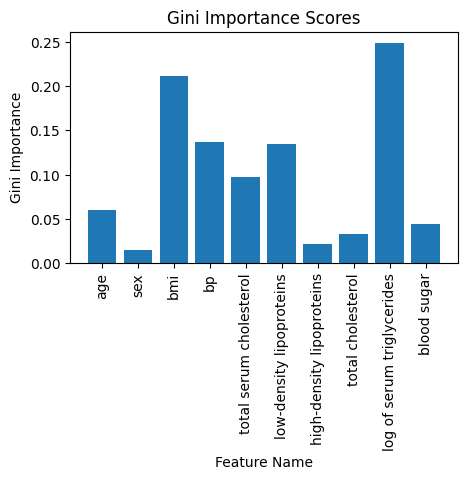

In [9]:
plt.figure(figsize=(5, 3))
plt.title('Gini Importance Scores')
plt.bar(feature_names, importances)
plt.xticks(rotation = 90)
plt.xlabel('Feature Name')
plt.ylabel('Gini Importance')
plt.show()

According to this graph, we can see that the log of serum triglycerides is the most important feature in our model, followed by BMI and blood pressure.